## Split into train, validation and test sets

In [1]:
from Prep import titanic
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split,  cross_val_score

#Set without scaling
X, X_test, y, y_test = train_test_split(titanic.iloc[:,1:], titanic.iloc[:,0], test_size = 0.1, stratify = titanic.iloc[:,0])
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.11, stratify = y)



print('Training set size: ', X_train.shape, '\n','Validation set size: ', X_validation.shape, '\n','Test set size:', X_test.shape)

Training set size:  (560, 10) 
 Validation set size:  (70, 10) 
 Test set size: (71, 10)


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel

# Model Shotgun Performance

In [3]:
X_scaled = X_train.copy()
sc_primo = StandardScaler()
X_scaled = sc_primo.fit_transform(X_scaled)



models = {'KNN: ': KNeighborsClassifier(),
         'Logistic: ': LogisticRegressionCV(),
         'Naive Bayes: ': GaussianNB(),
         'Support Vector Machine:' : SVC(),
         'Random Forest: ': RandomForestClassifier(n_estimators = 100, n_jobs = -1),
         'AdaBoost: ': AdaBoostClassifier(),
         'GBM: ' : GradientBoostingClassifier()}

for i, mod in enumerate(models.values()):
    print(list(models.keys())[i],cross_val_score(mod, X_scaled, y_train, cv = 10).mean())
    
    

KNN:  0.800109933926
Logistic:  0.810603782183
Naive Bayes:  0.769553429027
Support Vector Machine: 0.818034290271
Random Forest:  0.825050694919
AdaBoost:  0.793091250854
GBM:  0.834334130781


# Feature Selection

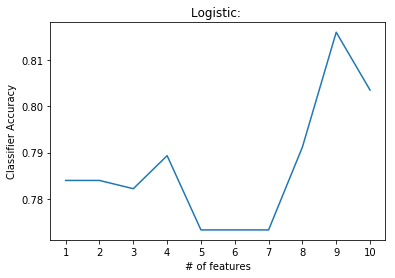

Feature to be Omitted:  ['Fare']


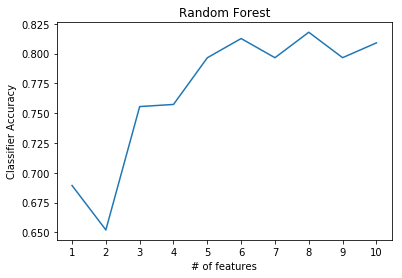

Feature to be Omitted:  ['Embarked_Q' 'Embarked_S']


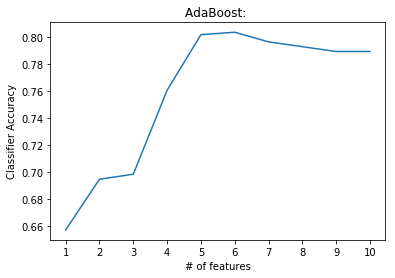

Feature to be Omitted:  ['Parch' 'Sex_female' 'Embarked_Q' 'Embarked_S']


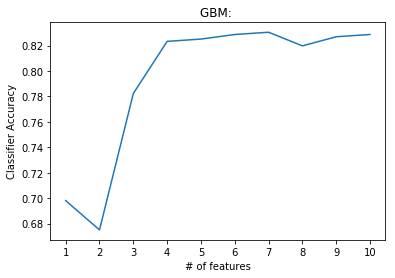

Feature to be Omitted:  ['Embarked_C' 'Embarked_Q' 'Embarked_S']


In [4]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
%matplotlib inline

#Dropping KNN and RandomForest
models = {'Logistic: ': LogisticRegressionCV(),
          'Random Forest': RandomForestClassifier(),
         'AdaBoost: ': AdaBoostClassifier(),
         'GBM: ' : GradientBoostingClassifier()}
for i , mod in enumerate(models.values()):
    r = RFECV(mod, cv = StratifiedKFold(5), scoring = 'accuracy')
    r.fit(X_train, y_train)
    plt.figure()
    plt.plot(range(1, len(r.grid_scores_)+1), r.grid_scores_)
    plt.xticks([1,2,3,4,5,6,7,8,9,10])
    plt.xlabel('# of features')
    plt.ylabel('Classifier Accuracy')
    plt.title(str(list(models.keys())[i]))
    plt.show()
    print('Feature to be Omitted: ', titanic.columns[1:][np.array(r.ranking_)!=1].values)
        

# Linear Seperability

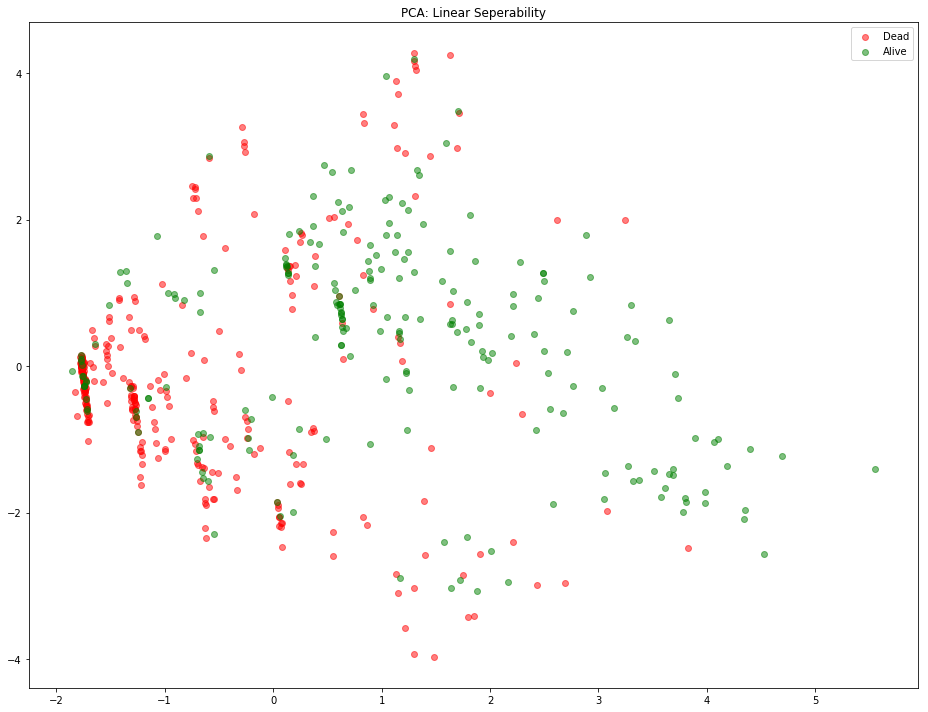

In [5]:
from sklearn.decomposition import PCA

X_pca = X_train.copy()
X_pca = StandardScaler().fit_transform(X_pca)


#instantiate PCA
pca = PCA(n_components = 2)
X_redu = pca.fit_transform(X_pca)


died = X_redu[y_train == 0]
live = X_redu[y_train == 1]
comp =[0,1]

fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(111)
ax.scatter(died[:,0].reshape(1,-1), died[:,1].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
ax.scatter(live[:,0].reshape(1,-1), live[:,1].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])
plt.tight_layout()
plt.show()

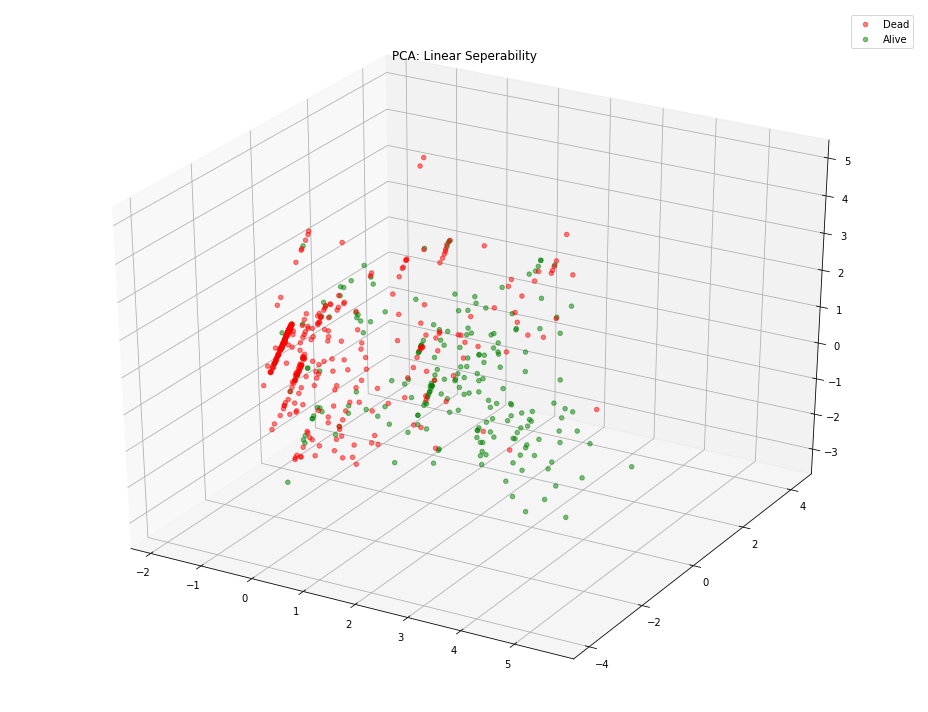

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X_pca = X_train.copy()
X_pca = StandardScaler().fit_transform(X_pca)

#instantiate PCA
pca = PCA(n_components = 3)
X_redu = pca.fit_transform(X_pca)


died = X_redu[y_train == 0]
live = X_redu[y_train == 1]
comp =[0,1]



fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(111, projection='3d', )
ax.scatter(died[:,0].reshape(1,-1), died[:,1].reshape(1,-1),died[:,2].reshape(1,-1), c = 'red', label = 'Dead', alpha = 0.5)
ax.scatter(live[:,0].reshape(1,-1), live[:,1].reshape(1,-1),live[:,2].reshape(1,-1), c = 'green', label = 'Survived', alpha = 0.5)
plt.title('PCA: Linear Seperability')
plt.legend(['Dead', 'Alive'])
plt.tight_layout()
plt.show()

# Model Tweaking

In [7]:
from sklearn.metrics import accuracy_score

# Overall classifier performance DataFrame
overall_res = pd.DataFrame(columns=['Classifier', 'Best_clf_retrained', 'Best_test_score', 'Validation'],)

#Only omitting Naive Bayes, since it consistently underperformed
models = {'KNN: ': KNeighborsClassifier(),
         'Logistic: ': LogisticRegressionCV(),
         'Support Vector Machine:' : SVC(),
         'Random Forest: ': RandomForestClassifier(n_estimators = 100, n_jobs = -1),
         'AdaBoost: ': AdaBoostClassifier(),
         'GBM: ' : GradientBoostingClassifier()}

for i, mod in enumerate(models.values()):
    print(list(models.keys())[i],cross_val_score(mod, X_scaled, y_train, cv = 10).mean())
    
    

KNN:  0.800109933926
Logistic:  0.810603782183
Support Vector Machine: 0.818034290271
Random Forest:  0.825178286626
AdaBoost:  0.793091250854
GBM:  0.834334130781


## KNN Tweak

In [8]:
clf = KNeighborsClassifier()
sc = StandardScaler()
clf_name = 'K Nearest Neighbors'


pipe = Pipeline([('sc', sc), ('knn', clf)])
fit_params = {'knn__n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}

gs = GridSearchCV(pipe, fit_params, cv = 10, n_jobs = -1, return_train_score = True)
gs.fit(X_train, y_train)

print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

pipe.set_params(knn__n_neighbors = gs.best_params_['knn__n_neighbors'])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_validation)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))


overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                            'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8196428571428571):
{'knn__n_neighbors': 6}
Best Estimator Validation Performance 0.8


## Logistic Tweak

In [9]:
log = LogisticRegressionCV()
sc = StandardScaler()
clf_name = 'Logistic Regression'



#Without Feature Selection
pipe = Pipeline([('sc', sc), ('classifier', log)])
fit_params = {}

gs = GridSearchCV(pipe, fit_params, cv = 10, n_jobs = -1, return_train_score = True)
gs.fit(X_train, y_train)

print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

print('Validation Performance of Best Performer', )


pipe.fit(X_train, y_train)
pred = pipe.predict(X_validation)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8107142857142857):
{}
Validation Performance of Best Performer
Best Estimator Validation Performance 0.757142857143


## Support Vector Machine Tweak

In [10]:
svc = SVC()
sc = StandardScaler()
clf_name = 'Support Vector Machine'


#Without Feature Selection
pipe = Pipeline([('sc', sc), ('classifier', svc)])
fit_params = {'classifier__kernel':['rbf','linear', 'poly'], 'classifier__degree':[2, 3, 4, 5]}

gs = GridSearchCV(pipe, fit_params, cv = 10, return_train_score = True)
gs.fit(X_train, y_train)



print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))

pipe.set_params(classifier__degree = gs.best_params_['classifier__degree'], classifier__kernel = gs.best_params_['classifier__kernel'])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_validation)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8178571428571428):
{'classifier__degree': 3, 'classifier__kernel': 'poly'}
Best Estimator Validation Performance 0.742857142857


## Random Forest Tweak

In [11]:
svc = RandomForestClassifier()
sc = StandardScaler()
clf_name = 'Random Forest Classifier'


#Without Feature Selection
pipe = Pipeline([('sc', sc), ('clf', svc)])
fit_params = {'clf__n_estimators':[10],
              'clf__min_samples_split':[2,3,4,5,6,7,8,9,10],
              'clf__min_samples_leaf':[1,2,3,4,5,6,7],
              'clf__max_features':[None,'auto']}

gs = GridSearchCV(pipe, fit_params, cv = 10,n_jobs = -1, return_train_score = True)
gs.fit(X_train, y_train)


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))


pipe.set_params(clf__min_samples_leaf = gs.best_params_['clf__min_samples_leaf'], clf__min_samples_split = gs.best_params_['clf__min_samples_split'])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_validation)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))

overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8428571428571429):
{'clf__max_features': 'auto', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 6, 'clf__n_estimators': 10}
Best Estimator Validation Performance 0.771428571429


## AdaBoost Tweak

In [12]:
from sklearn.tree import DecisionTreeClassifier
sc = StandardScaler()
clf = AdaBoostClassifier()
clf_name = 'AdaBoost'

# Make pipeline
pipe = Pipeline([('sc', sc),('clf', clf)])
fit_params = {'clf__n_estimators':[200],
              'clf__base_estimator':[
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=1, min_samples_split=2),                  
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=4), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=5), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=2, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',                                          
                      min_samples_leaf=2, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=6), 
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=3, min_samples_split=7), 
                  DecisionTreeClassifier(criterion='gini',   
                      min_samples_leaf=3, min_samples_split=8),                         
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=2, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=10),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=4, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=6, min_samples_split=13),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=8, min_samples_split=18),
                  DecisionTreeClassifier(criterion='gini',
                      min_samples_leaf=10, min_samples_split=22),
              ]}
                                                                   
# Initiate GridSearchCV
gs = GridSearchCV(pipe, fit_params, cv=10, n_jobs = -1, return_train_score = True)

# Fit GridSearchCV
gs.fit(X, y)

cv = pd.DataFrame(gs.cv_results_) # To check all the classifier performances


print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_, gs.best_params_))


pipe.set_params(clf__base_estimator = gs.best_params_['clf__base_estimator'])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_validation)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))



overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8063492063492064):
{'clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=13,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'clf__n_estimators': 200}
Best Estimator Validation Performance 0.742857142857


## GBM Tweak

In [13]:
svc = GradientBoostingClassifier()
sc = StandardScaler()
clf_name = 'Gradient Boosting Machine'


#Without Feature Selection
pipe = Pipeline([('sc', sc), ('clf', svc)])
fit_params = {'clf__loss': ['deviance', 'exponential'],
             'clf__learning_rate': [0.001, 0.01, 0.1, 1],
             'clf__max_depth': [3,4,5,6,7,8],
             'clf__min_samples_split': [2,3,4,5]}

gs = GridSearchCV(pipe, fit_params, n_jobs = -1, cv = 10, return_train_score = True)
gs.fit(X_train, y_train)

print('Best performing classifier parameters (score {}):\n{}'.format(gs.best_score_,gs.best_params_))


pipe.set_params(clf__learning_rate = gs.best_params_['clf__learning_rate'])
pipe.fit(X_train, y_train)
pred = pipe.predict(X_validation)
print('Best Estimator Validation Performance', accuracy_score(y_validation, pred))


overall_res = overall_res.append({'Classifier': clf_name, 'Best_clf_retrained': 
                            gs.best_estimator_, 
                            'Best_test_score': gs.best_score_,
                                  'Validation': accuracy_score(y_validation, pred)}, ignore_index=True);

Best performing classifier parameters (score 0.8339285714285715):
{'clf__learning_rate': 0.1, 'clf__loss': 'deviance', 'clf__max_depth': 3, 'clf__min_samples_split': 2}
Best Estimator Validation Performance 0.785714285714


In [14]:
overall_res['Validation'] = overall_res['Validation']*100
overall_res['Best_test_score'] = overall_res['Best_test_score']*100
overall_res

,Classifier,Best_clf_retrained,Best_test_score,Validation
0,K Nearest Neighbors,"Pipeline(memory=None,\n steps=[('sc', Stan...",81.964286,80.000000
1,Logistic Regression,"Pipeline(memory=None,\n steps=[('sc', Stan...",81.071429,75.714286
2,Support Vector Machine,"Pipeline(memory=None,\n steps=[('sc', Stan...",81.785714,74.285714
3,Random Forest Classifier,"Pipeline(memory=None,\n steps=[('sc', Stan...",84.285714,77.142857
4,AdaBoost,"Pipeline(memory=None,\n steps=[('sc', Stan...",80.634921,74.285714
5,Gradient Boosting Machine,"Pipeline(memory=None,\n steps=[('sc', Stan...",83.392857,78.571429


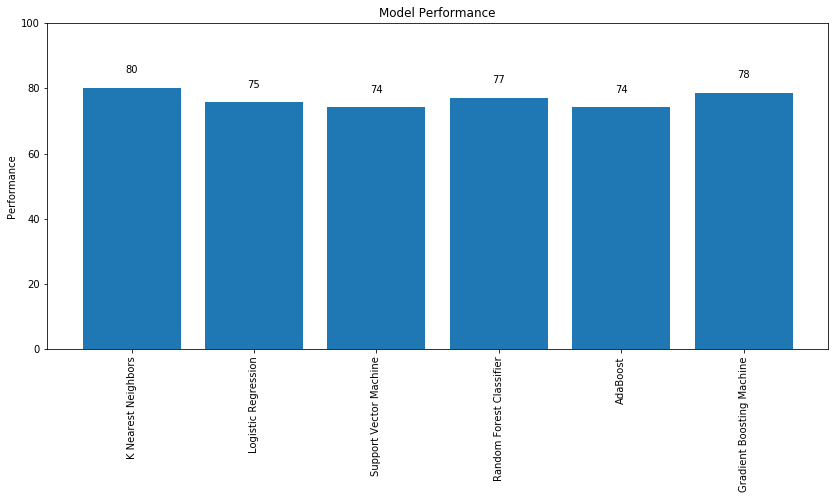

In [15]:
fig, ax = plt.subplots( figsize = (14,6))


barr = plt.bar(range(6),overall_res['Validation'])
plt.xticks(range(6), overall_res.Classifier, rotation = 90)
plt.title('Model Performance')
plt.ylabel('Performance')
plt.ylim((0,100))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    counter = 0
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(overall_res['Validation'].iloc[counter]),
                ha='center', va='bottom')
        counter+=1
        
autolabel(barr)
        
plt.show()

# Final Model

In [16]:
svc = GradientBoostingClassifier()
sc = StandardScaler()
clf_name = 'Gradient Boosting Machine'


#Without Feature Selection
pipe = Pipeline([('sc', sc), ('clf', svc)])
fit_params = {'clf__loss': ['deviance', 'exponential'],
             'clf__learning_rate': [0.001, 0.01, 0.1, 1],
             'clf__max_depth': [3,4,5,6,7,8],
             'clf__min_samples_split': [2,3,4,5]}

gs = GridSearchCV(pipe, fit_params, n_jobs = -1, cv = 10, return_train_score = True)
gs.fit(X, y)


pipe.set_params(clf__learning_rate = gs.best_params_['clf__learning_rate'])
pipe.fit(X, y)
pred = pipe.predict(X_test)
print('Best Estimator Test Performance', accuracy_score(y_test, pred))

Best Estimator Test Performance 0.746478873239


In [18]:
svc = GradientBoostingClassifier()
sc = StandardScaler()
clf_name = 'Gradient Boosting Machine'


#Without Feature Selection
pipe = Pipeline([('sc', sc), ('clf', svc)])
pipe.fit(X, y)
pred = pipe.predict(X_test)
print('Best Estimator Test Performance', accuracy_score(y_test, pred))

Best Estimator Test Performance 0.746478873239
